In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import matplotlib.pyplot as plt
import cv2
import numpy as np

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/facial-keypoints-detection/training.zip
/kaggle/input/facial-keypoints-detection/SampleSubmission.csv
/kaggle/input/facial-keypoints-detection/IdLookupTable.csv
/kaggle/input/facial-keypoints-detection/test.zip
/kaggle/input/model-so-far/model_so_far.pt


In [2]:
import torch
from torch.nn import functional as F
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader,random_split
from torch.optim import lr_scheduler
from torchvision import transforms
import torch.nn as nn
torch.manual_seed(0)

In [3]:
from sklearn.model_selection import train_test_split
from datetime import datetime
import time
import copy
from tqdm import tqdm
from numba import cuda
import gc


### TODO:

1) check fillna

2) compute loss only on nonnull examples

3) create dataloader - COMPLETED

# Load data

In [4]:
data_root = '/kaggle/input/facial-keypoints-detection/'
print(os.listdir(data_root))

['training.zip', 'SampleSubmission.csv', 'IdLookupTable.csv', 'test.zip']


In [5]:
import zipfile
with zipfile.ZipFile('/kaggle/input/facial-keypoints-detection/training.zip', 'r') as zip_obj:
   # Extract all the contents of zip file in current directory
   zip_obj.extractall('/kaggle/working/')
    
with zipfile.ZipFile('/kaggle/input/facial-keypoints-detection/test.zip', 'r') as zip_obj:
   # Extract all the contents of zip file in current directory
   zip_obj.extractall('/kaggle/working/')
    
print('After zip extraction:')
print(os.listdir("/kaggle/working/"))

After zip extraction:
['__notebook_source__.ipynb', 'training.csv', 'test.csv', '.virtual_documents']


In [6]:
data = pd.read_csv('/kaggle/working/training.csv')
# test = pd.read_csv('/kaggle/working/test.csv')

# Data info

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          7039 non-null   float64
 1   left_eye_center_y          7039 non-null   float64
 2   right_eye_center_x         7036 non-null   float64
 3   right_eye_center_y         7036 non-null   float64
 4   left_eye_inner_corner_x    2271 non-null   float64
 5   left_eye_inner_corner_y    2271 non-null   float64
 6   left_eye_outer_corner_x    2267 non-null   float64
 7   left_eye_outer_corner_y    2267 non-null   float64
 8   right_eye_inner_corner_x   2268 non-null   float64
 9   right_eye_inner_corner_y   2268 non-null   float64
 10  right_eye_outer_corner_x   2268 non-null   float64
 11  right_eye_outer_corner_y   2268 non-null   float64
 12  left_eyebrow_inner_end_x   2270 non-null   float64
 13  left_eyebrow_inner_end_y   2270 non-null   float

In [8]:
data.isnull().sum()

left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_b

In [9]:
def plot_dots(example):
    image = np.reshape(example['Image'].split(), (96,96)).astype(np.uint16)
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    for i in range(0, len(example)-1, 2):
        if not np.isnan(example[i]):
            x = example[i]
            y = example[i+1]
            image[round(y), round(x)] = (255, 0, 0)
    plt.imshow(image, cmap='Greys_r')
#     plt.subplot(121)
    plt.show()

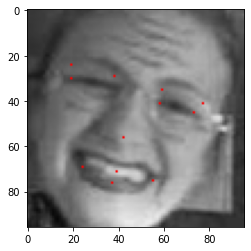

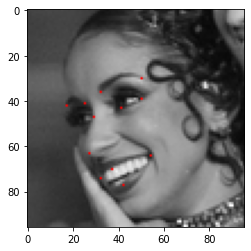

In [10]:
non_examples = data[data['left_eye_center_x'].isnull()]['left_eye_center_x'].index.values
for i in non_examples[:2]:
    plot_dots(data.iloc[i])

In [11]:
del data

# Data Augmentation

In [12]:
def horizontal_flip(image, points):
    image = np.array(image)
    image = image[:,::-1,:]
    image = torch.tensor(image.copy().reshape(96,96,1))
    points = np.array(points)
    points[::2] = 96 - points[::2]
    points = torch.from_numpy(points)
    return image, points

# Dataloader

In [13]:
def transform_images(image):
    if image is pd.Series:
        pass
    image = np.array(image.split(), dtype='float')
    image = image.reshape(96, 96, 1)
    return torch.from_numpy(image)

def transform_labeles(image):
    image = np.array(image, dtype='float')
    return torch.from_numpy(image)

In [14]:
class CustomImageDataset(Dataset):
    def __init__(self, file, test=False, transform=None, target_transform=None, fillna=False, augmentations=[]):
        self.data = pd.read_csv(file)
        if fillna:
            self.data = self.data.fillna(method=fillna)
        self.transform = transform
        self.target_transform = target_transform
        self.test = test
        self.augmentations = augmentations

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data.iloc[idx, 30]
        if self.transform:
            image = self.transform(image)
            
        label = self.data.iloc[idx, :30]
        if self.target_transform:
            label = self.target_transform(label)
                  
        if self.augmentations:
            for aug in self.augmentations:
                image, label = aug(image, label)
        return image/255, label

In [15]:
dataset = CustomImageDataset(file='/kaggle/working/training.csv', 
                             transform=transform_images, 
                             target_transform=transform_labeles, 
                            )
#                              fillna='ffill')

dataset_aug = CustomImageDataset(file='/kaggle/working/training.csv', 
                             transform=transform_images, 
                             target_transform=transform_labeles, 
                             augmentations=[horizontal_flip],
                                )
#                              fillna='ffill')

In [16]:
train_dataloader = DataLoader(dataset, batch_size=2, shuffle=False)
train_dataloader_aug = DataLoader(dataset_aug, batch_size=2, shuffle=False)

In [17]:
def plot_image_with_points(image, points):
    image = image * 255
    image = np.array(image).astype(np.uint16)
    points = points 
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    for i in range(0, len(points), 2):
        if not np.isnan(points[i]):
            x = points[i]
            y = points[i+1]
            image[round(int(y)), round(int(x))] = (255, 0, 0)
    return image

Feature batch shape: torch.Size([2, 96, 96, 1])
Labels batch shape: torch.Size([2, 30])


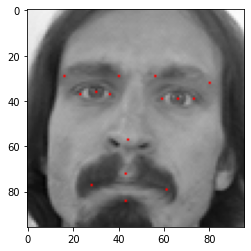

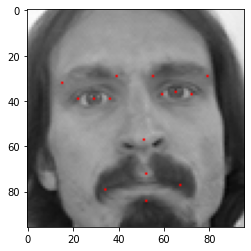

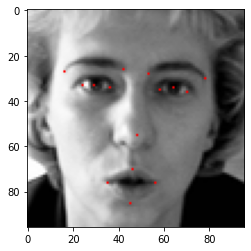

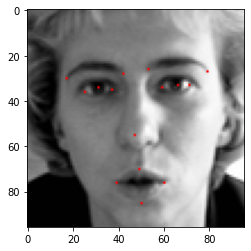

In [18]:
train_features_aug, train_labels_aug = next(iter(train_dataloader_aug))
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

for image, points, image_aug, points_aug in zip(train_features, train_labels, train_features_aug, train_labels_aug):
    image = plot_image_with_points(image, points)
    plt.imshow(image, cmap='Greys_r')
    plt.show()
    
    image = plot_image_with_points(image_aug, points_aug)
    plt.imshow(image, cmap='Greys_r')
    plt.show()

## Training Data

In [19]:
from torch.utils.data import random_split

# augmentation dataset
train_len_aug, val_len_aug = len(dataset_aug)-len(dataset_aug)//7, len(dataset_aug)//7
train_set_aug, val_set_aug = random_split(dataset_aug, [train_len_aug, val_len_aug], generator=torch.Generator().manual_seed(42))
print(f'Train aug len: {len(train_set_aug)}\nVal aug len: {len(val_set_aug)}')

# common dataset
train_len, val_len = len(dataset)-len(dataset)//7, len(dataset)//7
train_set, val_set = random_split(dataset, [train_len, val_len], generator=torch.Generator().manual_seed(42))
print(f'Train len: {len(train_set)}\nVal len: {len(val_set)}')

batch_size = 32
train_dataloader = DataLoader(train_set + train_set_aug, 
                              batch_size=batch_size, 
                              shuffle=True)
val_dataloader = DataLoader(val_set + val_set_aug, 
                            batch_size=batch_size, 
                            shuffle=True)

Train aug len: 6042
Val aug len: 1007
Train len: 6042
Val len: 1007


# first simple model

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("the device type is", device)

the device type is cuda:0


In [21]:
# Model Training Function
def train_model(model, n_epochs, train_loader, validation_loader, optimizer, scheduler, criterion, N_test, device):
    cost_list=[]
    val_loss_list=[]
    correct = 0
    
    
    # Loops for each epoch
    for epoch in tqdm(range(n_epochs)):
        print(f'epoch: {epoch}')
        # Keeps track of cost for each epoch
        COST=0
        # For each batch in train loader
        model.train() # 
        for x, y in train_loader:
            x,y = x.to(device), y.to(device)
            
            # Resets the calculated gradient value, this must be done each time as it accumulates if we do not reset
            optimizer.zero_grad()
            # Makes a prediction based on X value
            z = model(torch.swapaxes(x, 1, 3).double())
            # Measures the loss between prediction and acutal Y value
            loss = criterion(z, y)
            # Calculates the gradient value with respect to each weight and bias
            loss.backward()
            # Updates the weight and bias according to calculated gradient value
            optimizer.step()
            # Cumulates loss 
            COST+=loss.data

        # Saves cost of training data of epoch
        cost_list.append(COST.detach()/len(train_loader))
        # Keeps track of correct predictions
        loss_val=0
        # Perform a prediction on the validation  data  
        with torch.no_grad():
            model.eval()
            for x_test, y_test in validation_loader:
                x_test, y_test = x_test.to(device), y_test.to(device)
                # Makes a prediction
                z = model(torch.swapaxes(x_test, 1, 3))
                # Checks if the prediction matches the actual value
                loss_val += criterion(z, y_test).item()
            scheduler.step(loss_val)
            # Calcualtes accuracy and saves it
            loss_val = loss_val / len(validation_loader)
            val_loss_list.append(loss_val)
            print(f'train loss: {COST/len(train_loader)}', end='   ')
            print(f'val loss: {loss_val}')
        
#         model = model.to('cpu')
#         gc.collect()
#         torch.cuda.empty_cache()
        
    return cost_list, val_loss_list, model
     

## simple model pytorch

In [22]:
class SimpleConvNet(nn.Module):
    def __init__(self, input_channels, output_predicts):
        super(SimpleConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=input_channels, out_channels=4, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 96 -> 48
        self.batch1 = nn.BatchNorm2d(16)
        
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
#         self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 48 -> 24
        self.batch2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # 48 -> 24
        self.batch3 = nn.BatchNorm2d(256)
        
        self.fc1 = nn.Linear(24 * 24 * 256, 1024)  # !!!
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, output_predicts)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv1_2(x))
        x = self.pool1(x)
        x = self.batch1(x)
        
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv2_2(x))
        x = self.batch2(x)
        
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv3_2(x))
        x = self.pool3(x)
        x = self.batch3(x)
        
        x = x.view(-1, 24 * 24 * 256)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [23]:
# model = SimpleConvNet(1, 30).double()

In [24]:
resnet = models.resnet18(num_classes = 30)
resnet.inplanes = 96
resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
resnet.fc = nn.Sequential(
          nn.Linear(512, 512),
          nn.ReLU(),
          nn.Linear(512,30),
          nn.ReLU()
        )
model = resnet.double()

In [25]:
def RMSELoss_custom(pred, y):
    batch_size = len(y)
    result = (pred-y).nan_to_num()**2
    nun_values = (result == 0).sum()
    result = result.sum() / (batch_size * 30 - nun_values) # mean
    return torch.sqrt(result)

In [26]:
n_epochs=40
lr=10e-3
momentum=0.9
lr_scheduler=True
max_lr=0.01

# Size of the validation dataset
N_test = val_len

criterion = RMSELoss_custom
optimizer = torch.optim.Adam(model.parameters())
if lr_scheduler:
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',verbose=True, patience=3)

In [27]:
start_datetime = datetime.now()
start_time=time.time()
model = model.to(device)

accuracy_list, cost_list, model = train_model(model, n_epochs, train_dataloader, val_dataloader, optimizer, scheduler, criterion, N_test, device)

end_datetime = datetime.now()
current_time = time.time()
elapsed_time = current_time - start_time
print("elapsed time", elapsed_time )

  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 0


  2%|▎         | 1/40 [00:47<30:51, 47.46s/it]

train loss: 24.859251793679675   val loss: 24.109324156019827
epoch: 1


  5%|▌         | 2/40 [01:28<27:33, 43.52s/it]

train loss: 23.775684542459125   val loss: 23.506659830261594
epoch: 2


  8%|▊         | 3/40 [02:09<26:05, 42.32s/it]

train loss: 23.30995286769147   val loss: 23.320483846305052
epoch: 3


 10%|█         | 4/40 [02:49<25:00, 41.68s/it]

train loss: 23.086830984964575   val loss: 23.26233723239251
epoch: 4


 12%|█▎        | 5/40 [03:30<24:06, 41.33s/it]

train loss: 22.97794883729941   val loss: 23.067298873057286
epoch: 5


 15%|█▌        | 6/40 [04:13<23:46, 41.97s/it]

train loss: 20.817491193026378   val loss: 20.240790270780906
epoch: 6


 18%|█▊        | 7/40 [04:54<22:56, 41.72s/it]

train loss: 18.53272696904601   val loss: 18.74359452115364
epoch: 7


 20%|██        | 8/40 [05:35<22:04, 41.39s/it]

train loss: 18.218145914687454   val loss: 18.674305887108478
epoch: 8


 22%|██▎       | 9/40 [06:16<21:16, 41.16s/it]

train loss: 15.386159227237634   val loss: 15.518253458358368
epoch: 9


 25%|██▌       | 10/40 [06:57<20:34, 41.14s/it]

train loss: 14.442490351756193   val loss: 15.526321152068352
epoch: 10


 28%|██▊       | 11/40 [07:37<19:46, 40.93s/it]

train loss: 14.32632577531193   val loss: 15.517956235738497
epoch: 11


 30%|███       | 12/40 [08:18<19:05, 40.90s/it]

train loss: 14.166048901019412   val loss: 15.475669928520151
epoch: 12


 32%|███▎      | 13/40 [08:59<18:25, 40.95s/it]

train loss: 14.066275887797618   val loss: 15.551090724136778
epoch: 13


 35%|███▌      | 14/40 [09:40<17:42, 40.87s/it]

train loss: 14.002651511143574   val loss: 15.573945110037336
epoch: 14


 38%|███▊      | 15/40 [10:20<16:59, 40.78s/it]

train loss: 13.86776019864477   val loss: 15.552190032301738
epoch: 15


 40%|████      | 16/40 [11:02<16:22, 40.92s/it]

train loss: 13.731504897135947   val loss: 15.251015811752238
epoch: 16


 42%|████▎     | 17/40 [11:43<15:40, 40.90s/it]

train loss: 10.955624248753521   val loss: 8.9657471406425
epoch: 17


 45%|████▌     | 18/40 [12:23<14:56, 40.76s/it]

train loss: 6.131191676889801   val loss: 9.191330339949955
epoch: 18


 48%|████▊     | 19/40 [13:04<14:15, 40.73s/it]

train loss: 5.139861929399086   val loss: 9.217900645827024
epoch: 19


 50%|█████     | 20/40 [13:45<13:35, 40.78s/it]

train loss: 4.5803422018137985   val loss: 9.193484614602243
epoch: 20


 52%|█████▎    | 21/40 [14:25<12:53, 40.73s/it]

train loss: 3.9837380048922046   val loss: 8.858900671327925
epoch: 21


 55%|█████▌    | 22/40 [15:06<12:12, 40.70s/it]

train loss: 3.5865876871656552   val loss: 9.167042583515878
epoch: 22


 57%|█████▊    | 23/40 [15:47<11:32, 40.76s/it]

train loss: 3.393555111865081   val loss: 8.951557882381705
epoch: 23


 60%|██████    | 24/40 [16:27<10:52, 40.75s/it]

train loss: 3.2719231300475182   val loss: 9.065106160232308
epoch: 24


 62%|██████▎   | 25/40 [17:08<10:10, 40.72s/it]

Epoch 00025: reducing learning rate of group 0 to 1.0000e-04.
train loss: 3.166545486855236   val loss: 9.010457172808936
epoch: 25


 65%|██████▌   | 26/40 [17:49<09:32, 40.86s/it]

train loss: 2.5104943992528823   val loss: 8.704279473105407
epoch: 26


 68%|██████▊   | 27/40 [18:30<08:49, 40.70s/it]

train loss: 2.1708054422633576   val loss: 8.797220757676179
epoch: 27


 70%|███████   | 28/40 [19:10<08:08, 40.73s/it]

train loss: 2.04616503944427   val loss: 8.794535730846423
epoch: 28


 72%|███████▎  | 29/40 [19:51<07:27, 40.67s/it]

train loss: 2.0026912463103486   val loss: 8.768554590044015
epoch: 29


 75%|███████▌  | 30/40 [20:32<06:46, 40.67s/it]

Epoch 00030: reducing learning rate of group 0 to 1.0000e-05.
train loss: 1.9533472759691317   val loss: 8.806460530918615
epoch: 30


 78%|███████▊  | 31/40 [21:12<06:06, 40.69s/it]

train loss: 1.9174234285844736   val loss: 8.732439780545032
epoch: 31


 80%|████████  | 32/40 [21:53<05:25, 40.67s/it]

train loss: 1.9024245788747163   val loss: 8.789668496942268
epoch: 32


 82%|████████▎ | 33/40 [22:34<04:44, 40.71s/it]

train loss: 1.8956101435190054   val loss: 8.78346605825393
epoch: 33


 85%|████████▌ | 34/40 [23:14<04:04, 40.70s/it]

Epoch 00034: reducing learning rate of group 0 to 1.0000e-06.
train loss: 1.8903075684819801   val loss: 8.855461666749328
epoch: 34


 88%|████████▊ | 35/40 [23:55<03:23, 40.67s/it]

train loss: 1.8831489942179618   val loss: 8.78705907946466
epoch: 35


 90%|█████████ | 36/40 [24:36<02:42, 40.61s/it]

train loss: 1.8813857040509643   val loss: 8.757590142597211
epoch: 36


 92%|█████████▎| 37/40 [25:17<02:02, 40.75s/it]

train loss: 1.8826691856212718   val loss: 8.689477682310287
epoch: 37


 95%|█████████▌| 38/40 [25:57<01:21, 40.70s/it]

train loss: 1.8811835064174742   val loss: 8.732375765231755
epoch: 38


 98%|█████████▊| 39/40 [26:38<00:40, 40.65s/it]

train loss: 1.8767831270501054   val loss: 8.767999432741448
epoch: 39


100%|██████████| 40/40 [27:18<00:00, 40.97s/it]

train loss: 1.879206029182142   val loss: 8.783365644839979
elapsed time 1642.2567172050476


In [28]:
!ls

__notebook_source__.ipynb  test.csv  training.csv


In [29]:
# model.load_state_dict(torch.load('/kaggle/working/' + 'model_so_far.pt'))

In [30]:
# torch.save(model.state_dict(), '/kaggle/working/' + 'model_so_far.pt')

In [31]:
# plt.plot(list(map(float, cost_list)))

In [32]:
image, label = next(iter(train_dataloader))
print(image.shape)
image, label = image.to(device), label.to(device)
z = model(torch.swapaxes(image, 1, 3).double())
print(z.shape)

torch.Size([32, 96, 96, 1])
torch.Size([32, 30])


In [33]:
def plot_image_with_points_and_predicts(image, points, pred):
    image = image * 255
    image = np.array(image).astype(np.uint16)
    points = points 
    target_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    preds = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    for i in range(0, len(points), 2):
        if not np.isnan(points[i]):
            x_target = points[i]
            y_target = points[i+1]
            x_pred = pred[i]
            y_pred = pred[i+1]
            target_image[round(int(y_target)), round(int(x_target))] = (255, 0, 0)
            preds[round(int(y_pred)), round(int(x_pred))] = (255, 0, 0)
    return target_image, preds

Feature batch shape: torch.Size([32, 96, 96, 1])
Labels batch shape: torch.Size([32, 30])
[8 8 8] [8 8 8]


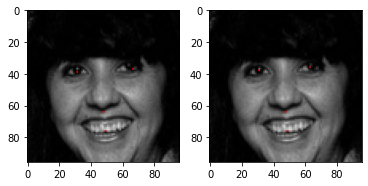

[101 101 101] [101 101 101]


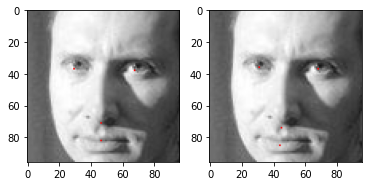

[252 252 252] [252 252 252]


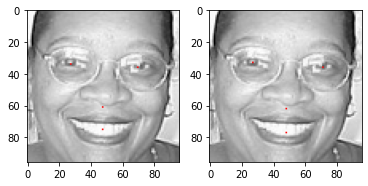

[184 184 184] [184 184 184]


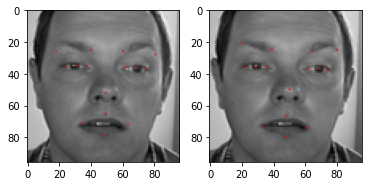

[255 255 255] [255 255 255]


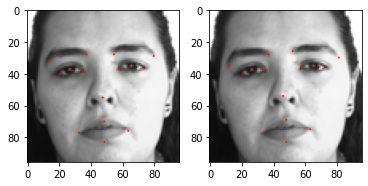

[179 179 179] [179 179 179]


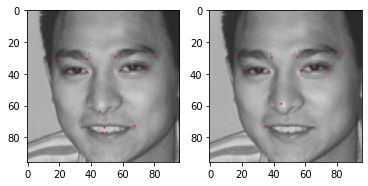

[39 39 39] [39 39 39]


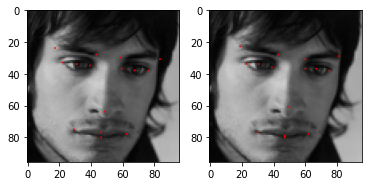

[193 193 193] [193 193 193]


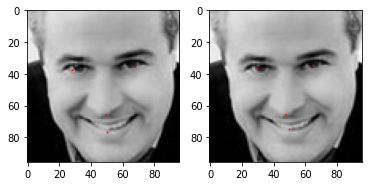

[181 181 181] [181 181 181]


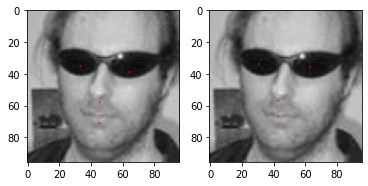

[102 102 102] [102 102 102]


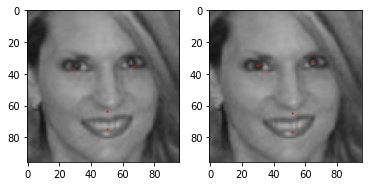

[150 150 150] [150 150 150]


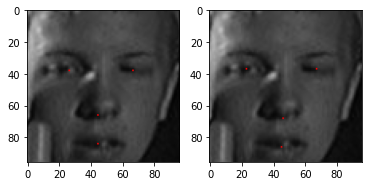

[227 227 227] [227 227 227]


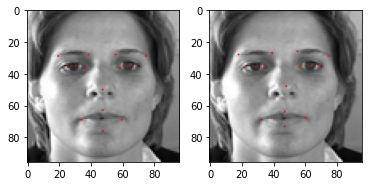

[180 180 180] [180 180 180]


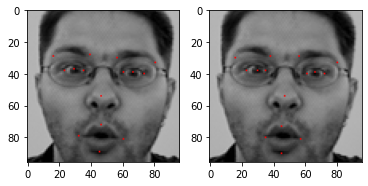

[38 38 38] [38 38 38]


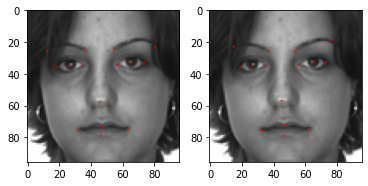

[86 86 86] [86 86 86]


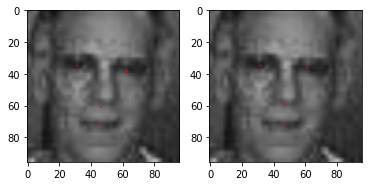

[17 17 17] [17 17 17]


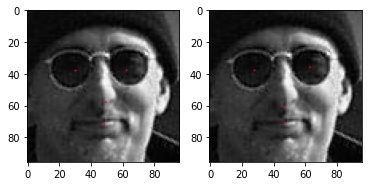

[41 41 41] [41 41 41]


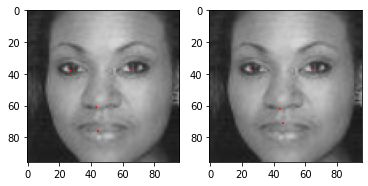

[24 24 24] [24 24 24]


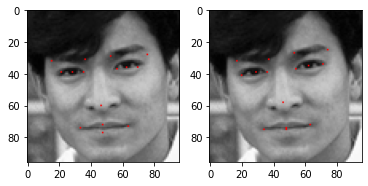

[74 74 74] [74 74 74]


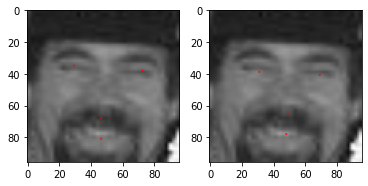

[193 193 193] [193 193 193]


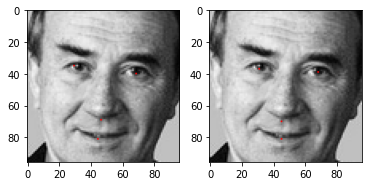

[6 6 6] [6 6 6]


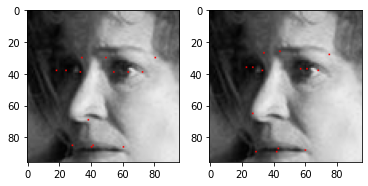

[12 12 12] [12 12 12]


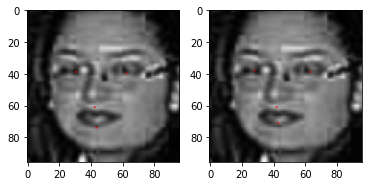

[75 75 75] [75 75 75]


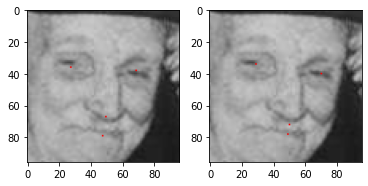

[170 170 170] [170 170 170]


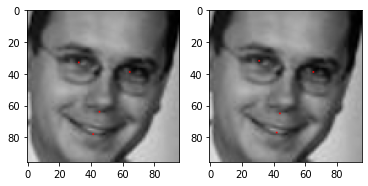

[90 90 90] [90 90 90]


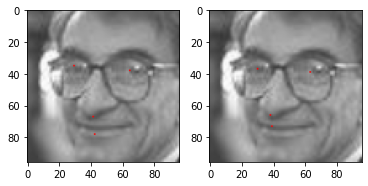

[177 177 177] [177 177 177]


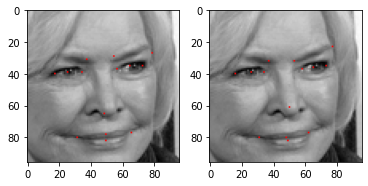

[83 83 83] [83 83 83]


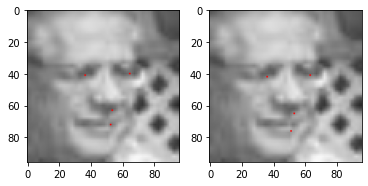

[255 255 255] [255 255 255]


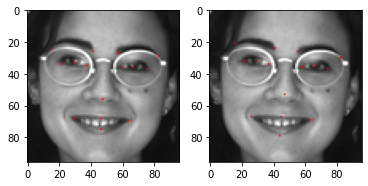

[193 193 193] [193 193 193]


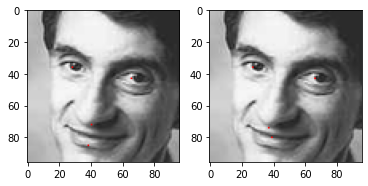

[29 29 29] [29 29 29]


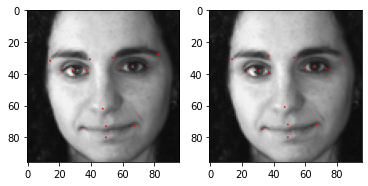

[37 37 37] [37 37 37]


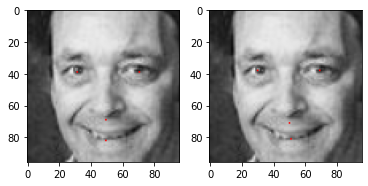

[145 145 145] [145 145 145]


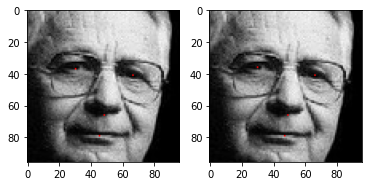

In [34]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

for image, points in zip(train_features, train_labels):

    with torch.no_grad():
        model.eval()
        z = model(torch.swapaxes(torch.unsqueeze(image.to(device), 0), 1, 3).double())
        z = z.cpu()
        z = z
#     new_image = image.copy()
    
    image, new_image = plot_image_with_points_and_predicts(image, points, z[0])
    print(image[0][0], new_image[0][0])
            
#     plt.imshow(image, cmap='Greys_r')
    
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(new_image, cmap='Greys_r')
    axarr[1].imshow(image, cmap='Greys_r')
    
    plt.show()

# Prediction

In [35]:
test = pd.read_csv('/kaggle/working/test.csv')
data = pd.read_csv('/kaggle/working/training.csv')

In [36]:
class CustomImageTestset(Dataset):
    def __init__(self, file, transform=None):
        self.data = pd.read_csv(file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
            
        return image

In [37]:
dataset_test = CustomImageTestset(file='/kaggle/working/test.csv', 
                             transform=transform_images)
test_dataloader = DataLoader(dataset_test, batch_size=64, shuffle=False)

In [38]:
predict = []
for image in test_dataloader:
    with torch.no_grad():
        model.eval()
        z = model(torch.swapaxes(image.to(device), 1, 3).double())
        z = z.cpu()
        predict += list(z)
        

In [39]:
len(predict)

1783

In [40]:
inp = '../input/'
keypts_labels = data.columns.tolist()
id_lookup = pd.read_csv(inp + 'facial-keypoints-detection/IdLookupTable.csv')
id_lookup_features = list(id_lookup['FeatureName'])
id_lookup_image = list(id_lookup['ImageId'])

for i in range(len(id_lookup_features)):
    id_lookup_features[i] = keypts_labels.index(id_lookup_features[i])
    
location = []
for i in range(len(id_lookup_features)):
    value = float(predict[id_lookup_image[i]-1][id_lookup_features[i]])
    if value < 0:
        value = 0
    if value > 96:
        value = 96
    location.append(value)
    
id_lookup['Location'] = location
submission = id_lookup[['RowId', 'Location']]
submission.to_csv('submission.csv',index=False)
print('Total test images labeled:')
print(len(submission) - 1)
print('Submission file is ready')

Total test images labeled:
27123
Submission file is ready
